### Zadania

Lista składa się z dwóch sekcji: pierwsza (zadania 1 i 2) dotyczy metod detekcji krawędzi, druga (zadania 3 i 4) operacji na histogramach.

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

##### Zad. 1: Wyznaczenie gradientów

Wykonaj dla obrazu `coins` sztuczny obraz ilustrujący wielkość (moduł) wektora gradientu w danym punkcie. Do wyświetlenia użyj [mapy kolorów](https://matplotlib.org/stable/tutorials/colors/colormaps.html) `hot` do oznaczenia wielkości gradientu odpowiednim kolorem – im większa wartość, tym bardziej czerwony (_mapa ciepła_).

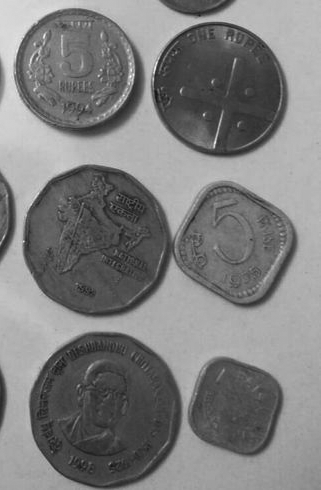

In [3]:
coins = cv2.imread('../dane-1-4/Monety_szare.bmp', cv2.IMREAD_GRAYSCALE)
Image.fromarray(coins)

Rozwiązanie:

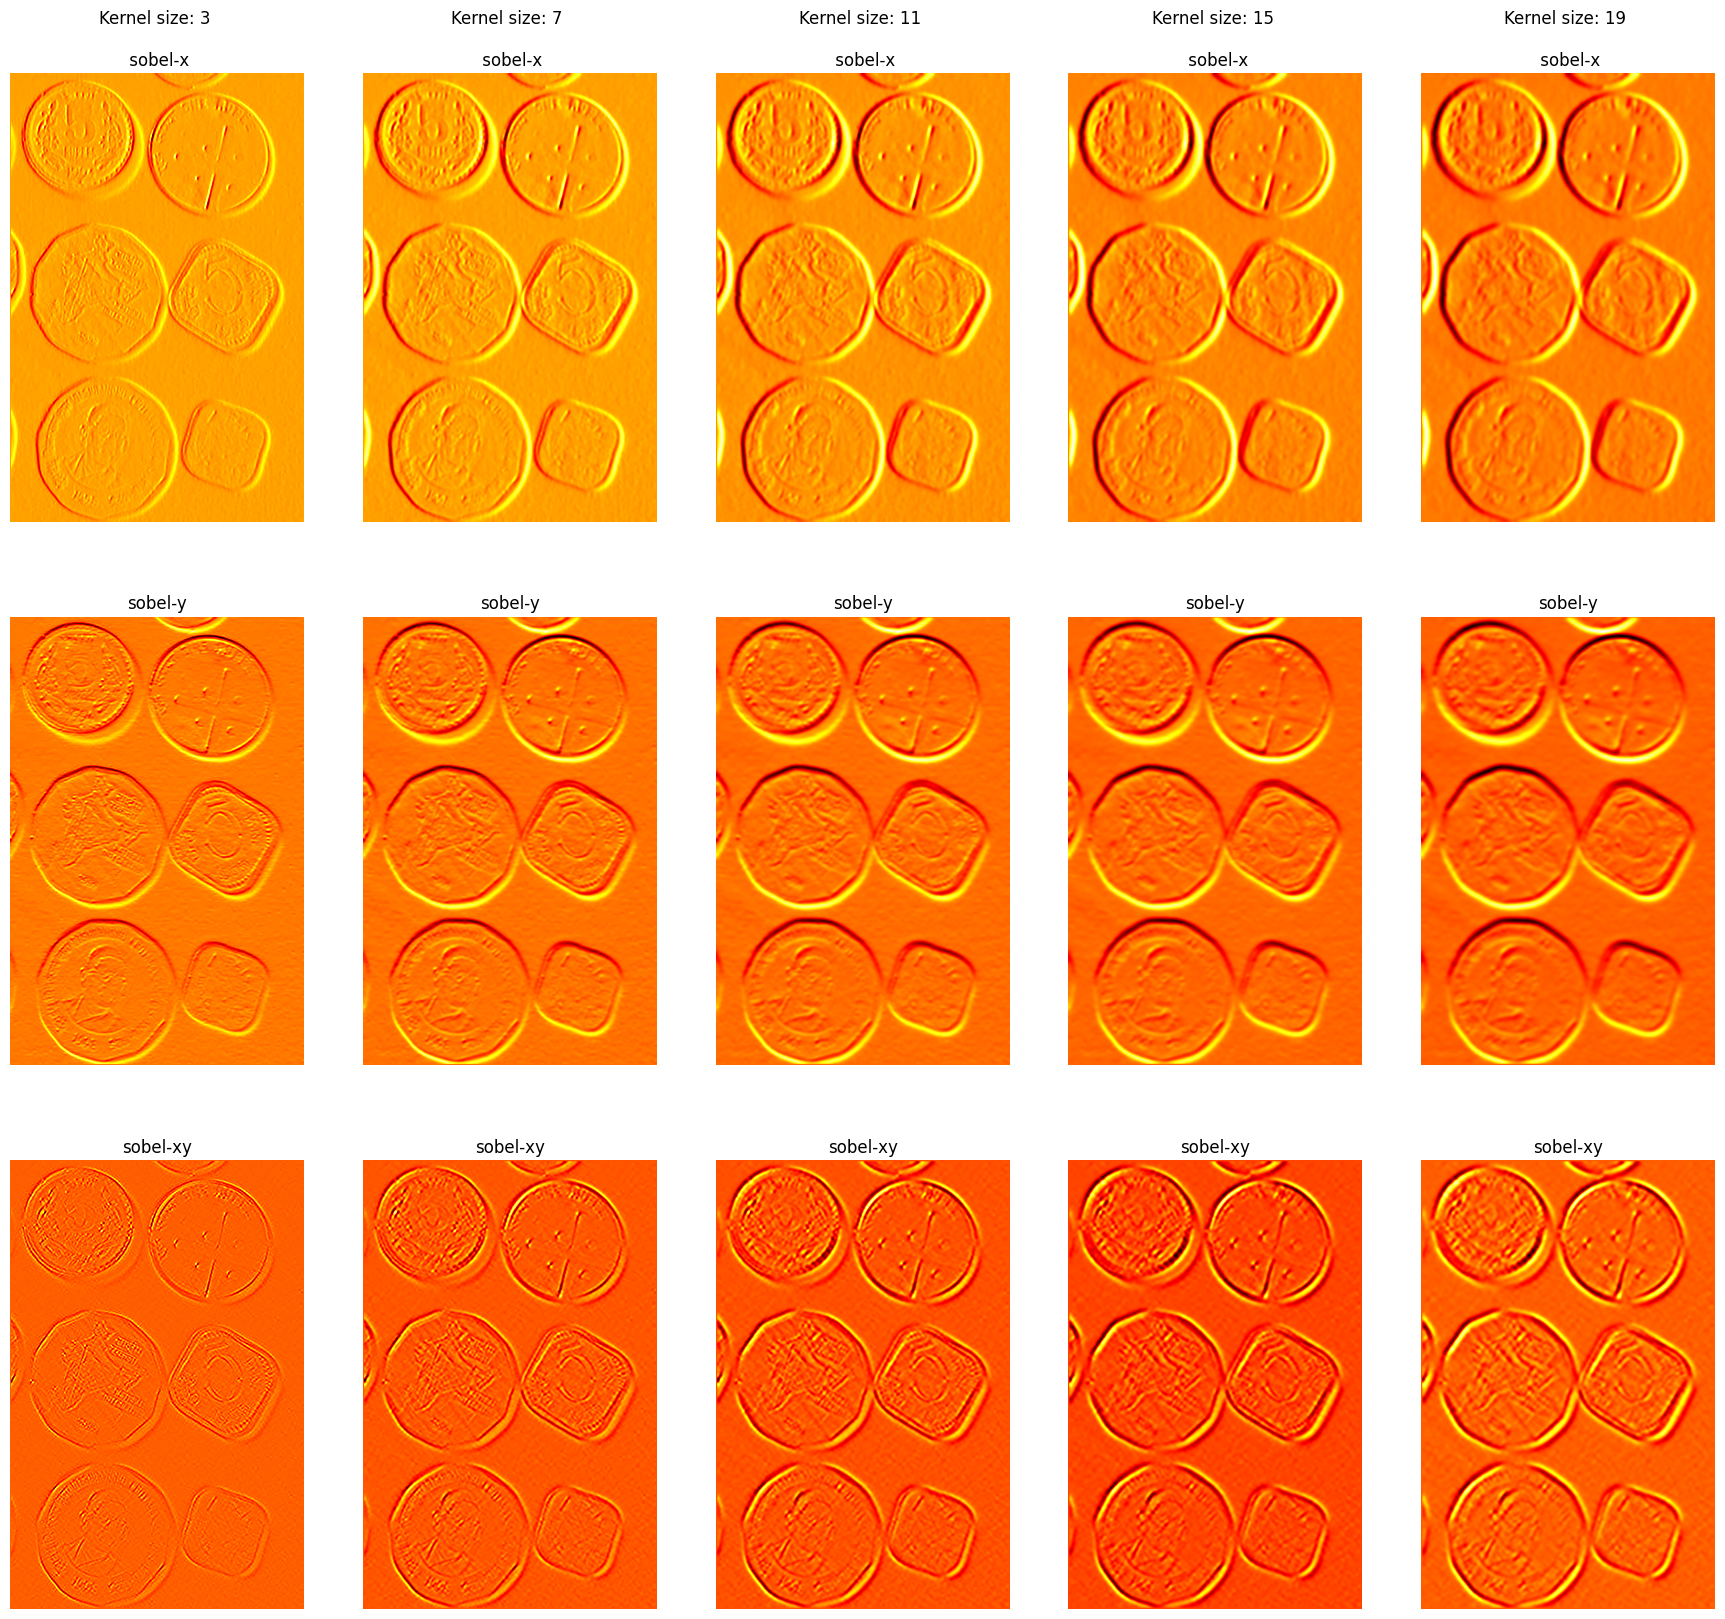

In [4]:
def plot_sobel(data):
    fig, axes = plt.subplots(3, 5, figsize=(22, 20))

    for ax, (ksize, sobelx, sobely, sobelxy) in zip(axes.T, data):
        ax[0].imshow(sobelx, cmap="hot")
        ax[1].imshow(sobely, cmap="hot")
        ax[2].imshow(sobelxy, cmap="hot")

        ax[0].axis("off")
        ax[1].axis("off")
        ax[2].axis("off")

        ax[0].set_title(f"Kernel size: {ksize} \n\n sobel-x")
        ax[1].set_title("sobel-y")
        ax[2].set_title("sobel-xy")

    plt.show()

data = [
    (
        ksize,
        cv2.Sobel(coins, cv2.CV_64F, 1, 0, ksize=ksize),
        cv2.Sobel(coins, cv2.CV_64F, 0, 1, ksize=ksize),
        cv2.Sobel(coins, cv2.CV_64F, 1, 1, ksize=ksize)
    )
    for ksize in [3, 7, 11, 15, 19]
    
]
plot_sobel(data)

Wraz ze wzrostem kernela, intenstywności większych znajdywanych krawędzi są większe. Oznaczane krawędzie są też grubsze niż przy mniejszych kernelach.

---

##### Zad. 2: Detekcja krawędzi

Przeprowadź z obrazem `coins_noise` takie przekształcenia, aby zmaksymalizować możliwość rozpoznania obiektów poprzez detekcję krawędzi. Wykorzystaj filtr Canny'ego dla różnych wartości progów oraz filtry redukcji szumu.

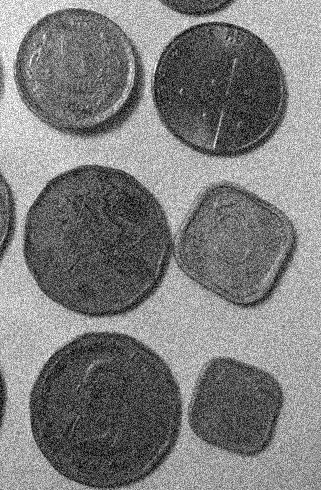

In [2]:
coins_noise = cv2.imread('../dane-1-4/Monety_szare_szum.bmp', cv2.IMREAD_GRAYSCALE)
Image.fromarray(coins_noise)

Rozwiązanie:

a) Bez redukcji szumu (domyślnie canny robi redukcję szumu w pierwszym kroku przy użyciu filtru gaussa)

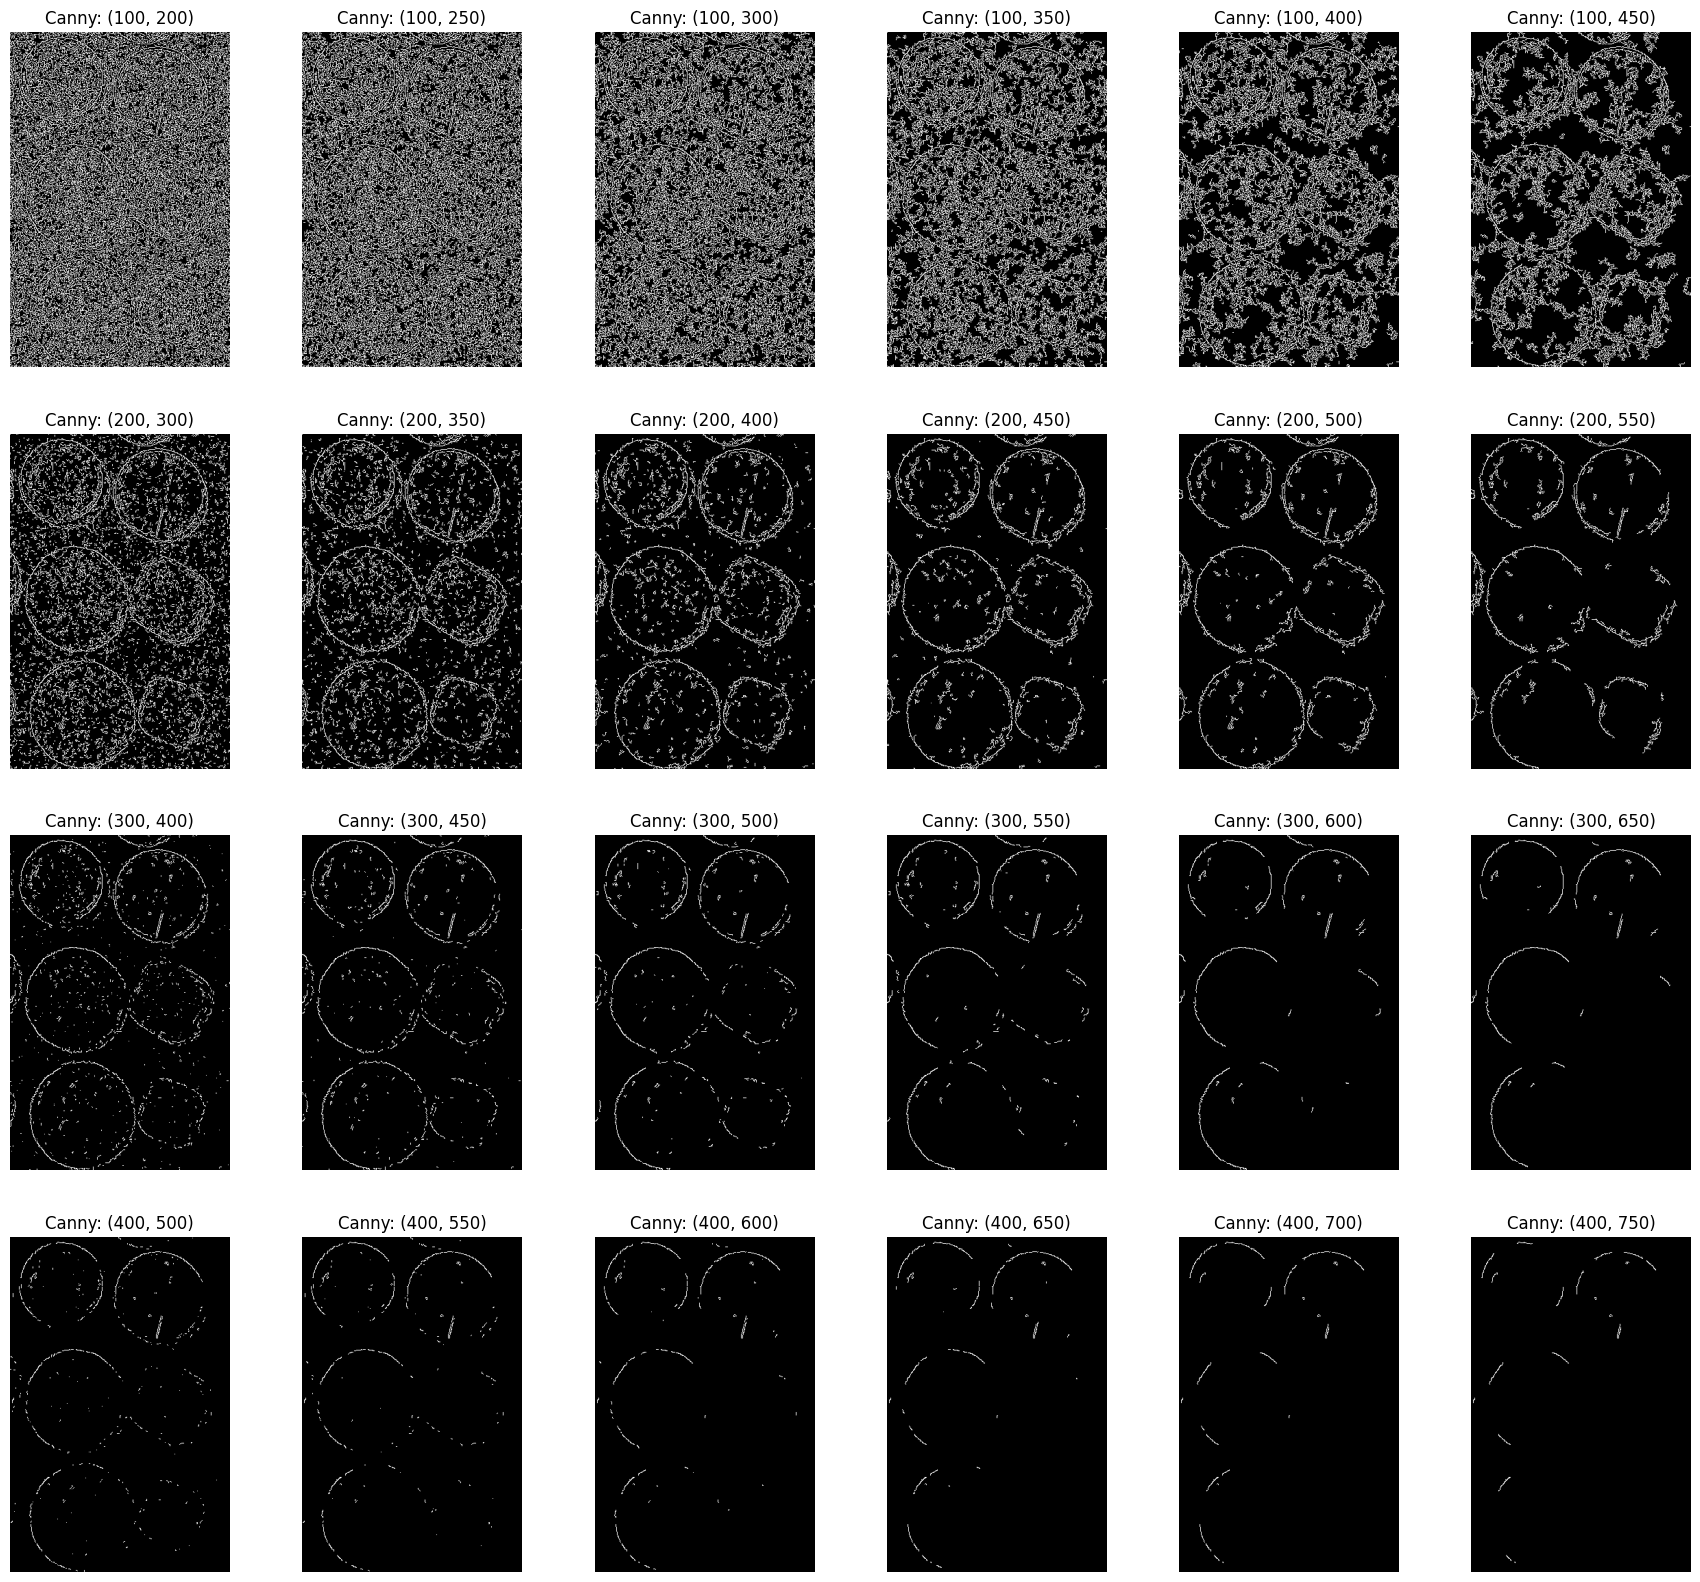

In [6]:
def plot_canny(data):
    fig, axes = plt.subplots(4, 6, figsize=(22, 20))

    for ax, (t1, t2, canny) in zip(axes.flatten(), data):
        ax.imshow(canny, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Canny: ({t1}, {t2})")

    plt.show()

data = [
    (t1, t1 + t2, cv2.Canny(coins_noise, threshold1=t1, threshold2=t1 + t2))
    for t1 in [100, 200, 300, 400] for t2 in [100, 150, 200, 250, 300, 350]    
]
plot_canny(data)

Aby odfiltrować wąskie krawędzie musimy odpowiednio ustawić dolny próg - widać to w kolumnach. Górny próg pozwala nam odfiltrowywać większe krawędzie - co widać w wierszach. Kluczowy dla działania filtru canny jest obszar pomiędzy progami, gdzie decyzja o uznaniu aktywowanej krawędzi za krawędź docelową, jest uznawana na podstawie połączenia z krawędziami powyżej progu górnego. Dlatego, ustawienia progów w taki sposób, że różnica pomiędzy nimi jest istotnej wielkości, zdaje się dawać najlepsze rezultaty.

b) Redukcja szumu z filtrem blur (wygładzanie przez średnią)

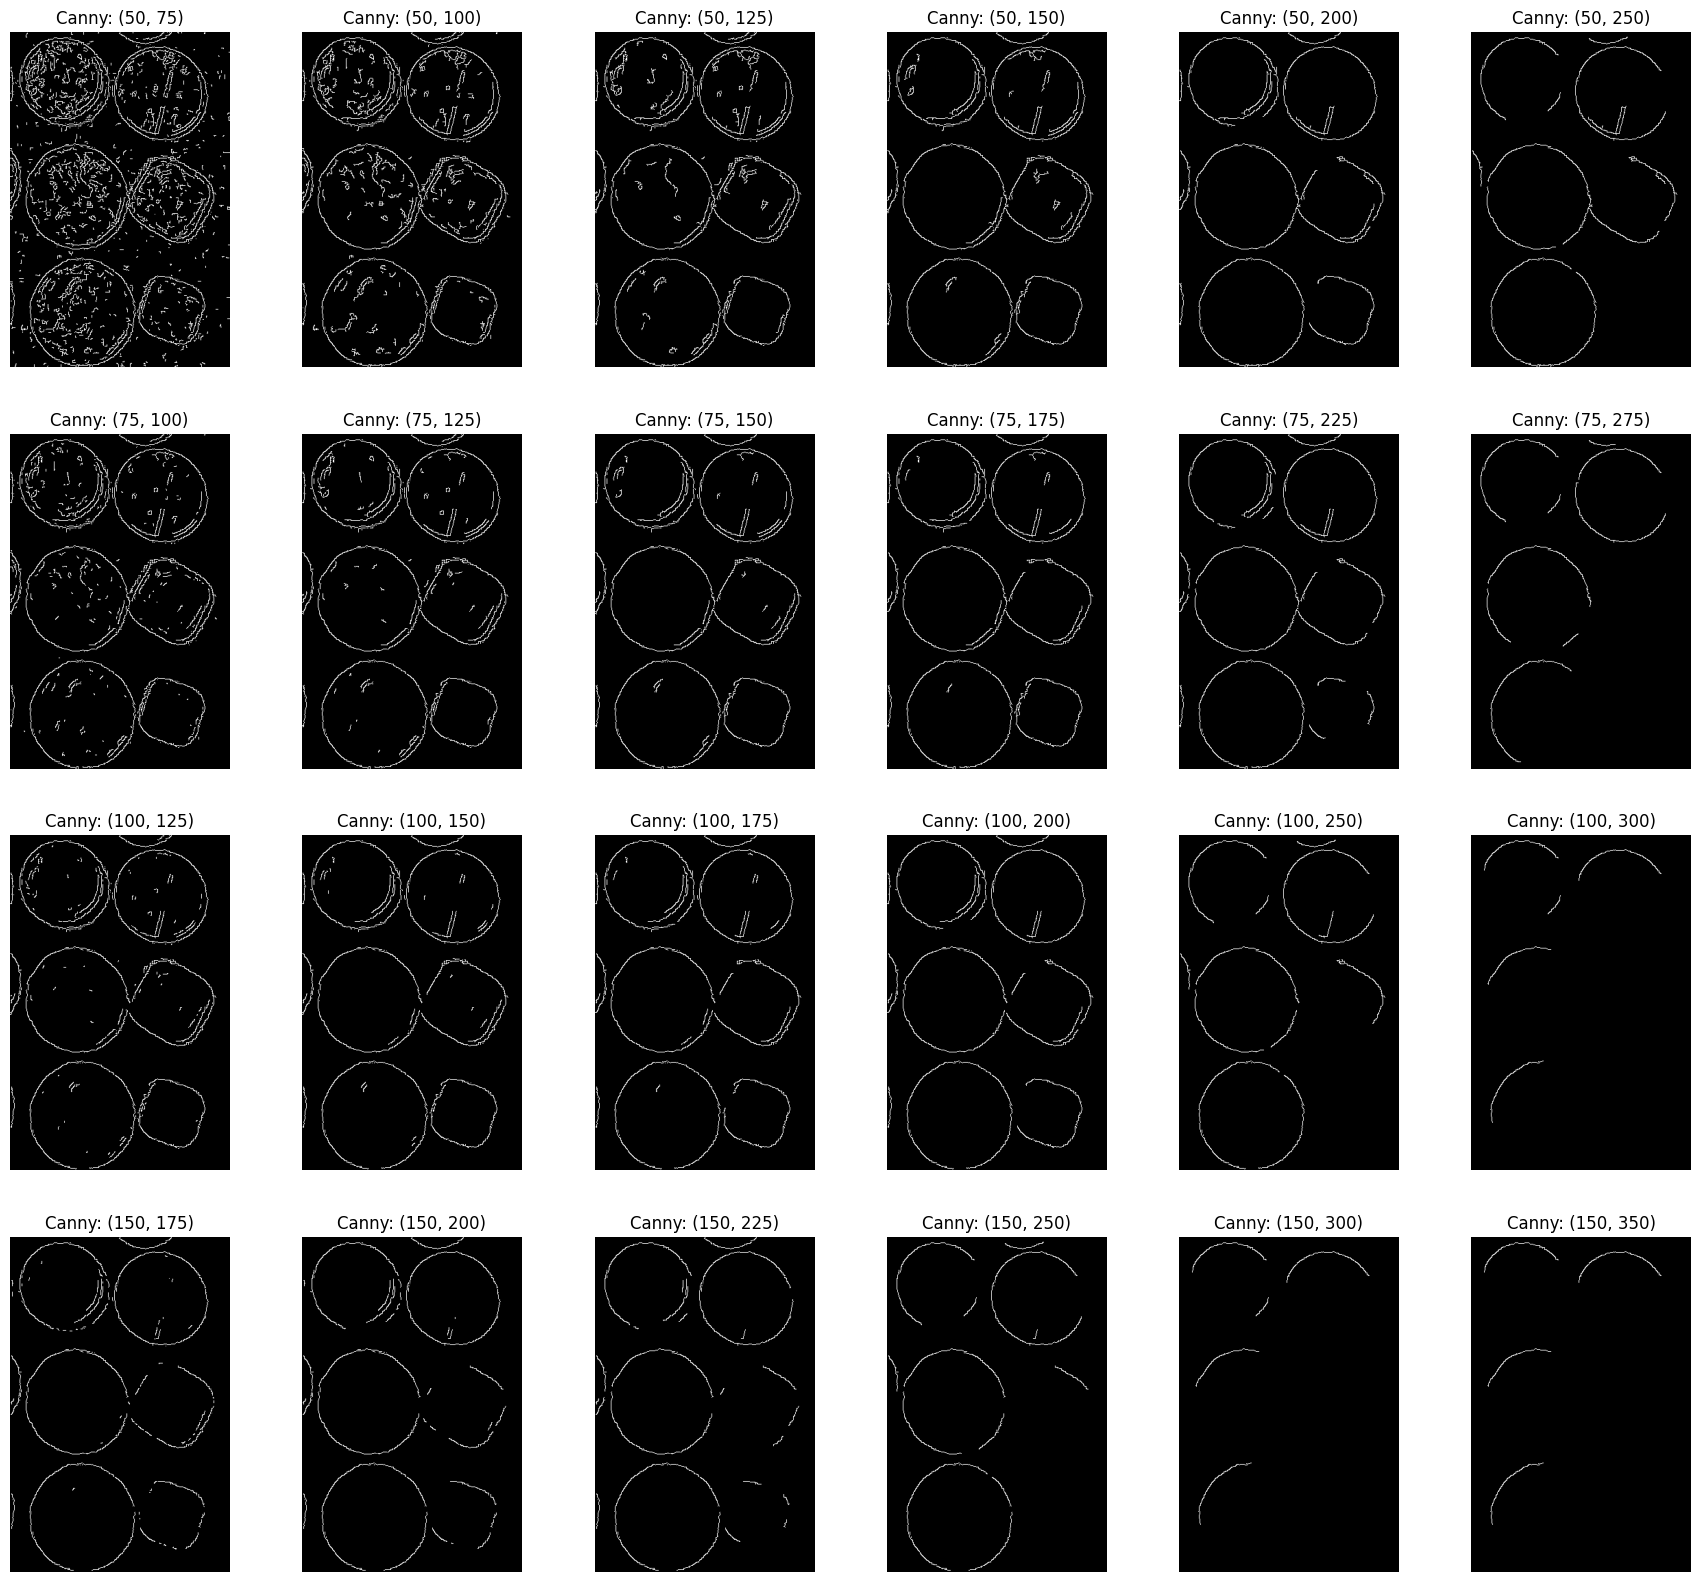

In [14]:
data = [
    (t1, t1 + t2, cv2.Canny(cv2.blur(coins_noise, (5, 5)), threshold1=t1, threshold2=t1 + t2))
    for t1 in [50, 75, 100, 150] for t2 in [25, 50, 75, 100, 150, 200]    
]
plot_canny(data)

Wygładzenie przy użyciu filtra uśredniającego ewidentnie podniosło jakość wyników. Małe krawędzie zostały zniwelowane, a większe w miejscach, gdzie intensywność spadała, wygładzone co daje bardziej pełne kontury i mniejszą ilość artefaktów.

---

##### Zad. 3: Wyrównanie histogramu

Wyrównaj histogram obrazu `coins_noise`. Wyniki zaprezentuj za pomocą obrazów i towarzyszących im histogramów.

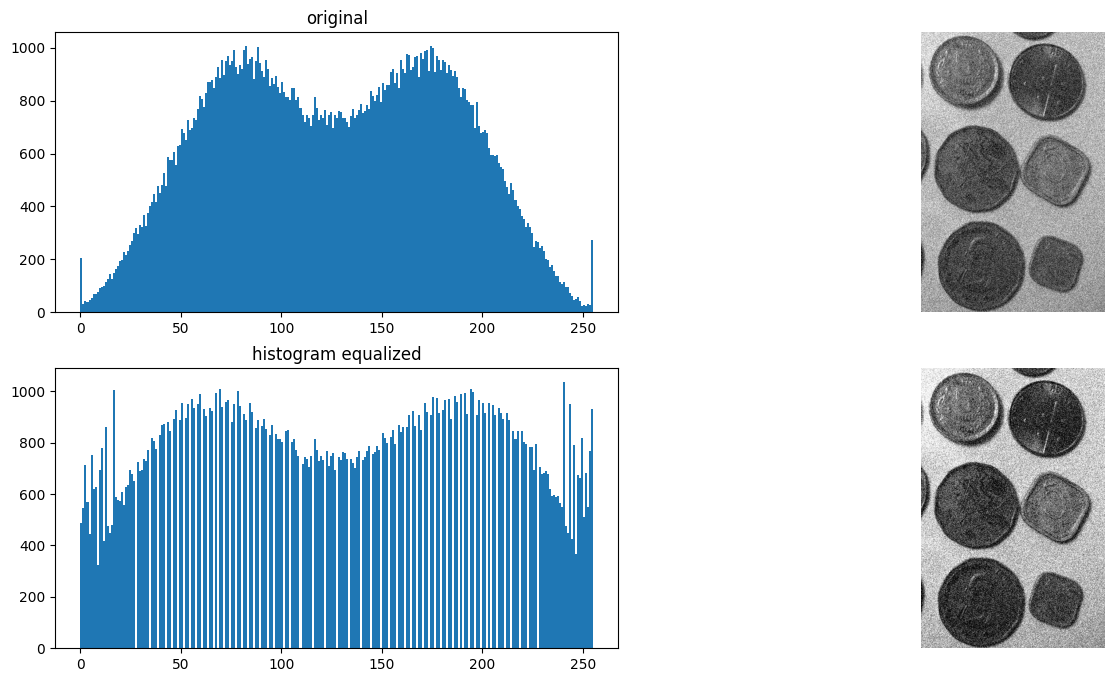

In [29]:
def plot_hists(data):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    
    for ax, (key, img) in zip(axes, data.items()):
        ax[0].set_title(key)
        ax[0].hist(img.flatten(), bins=255)
        ax[1].imshow(img, cmap="gray")
        ax[1].axis("off")

    plt.show()

data = {
    "original": coins_noise,
    "histogram equalized": cv2.equalizeHist(coins_noise)
}
plot_hists(data)

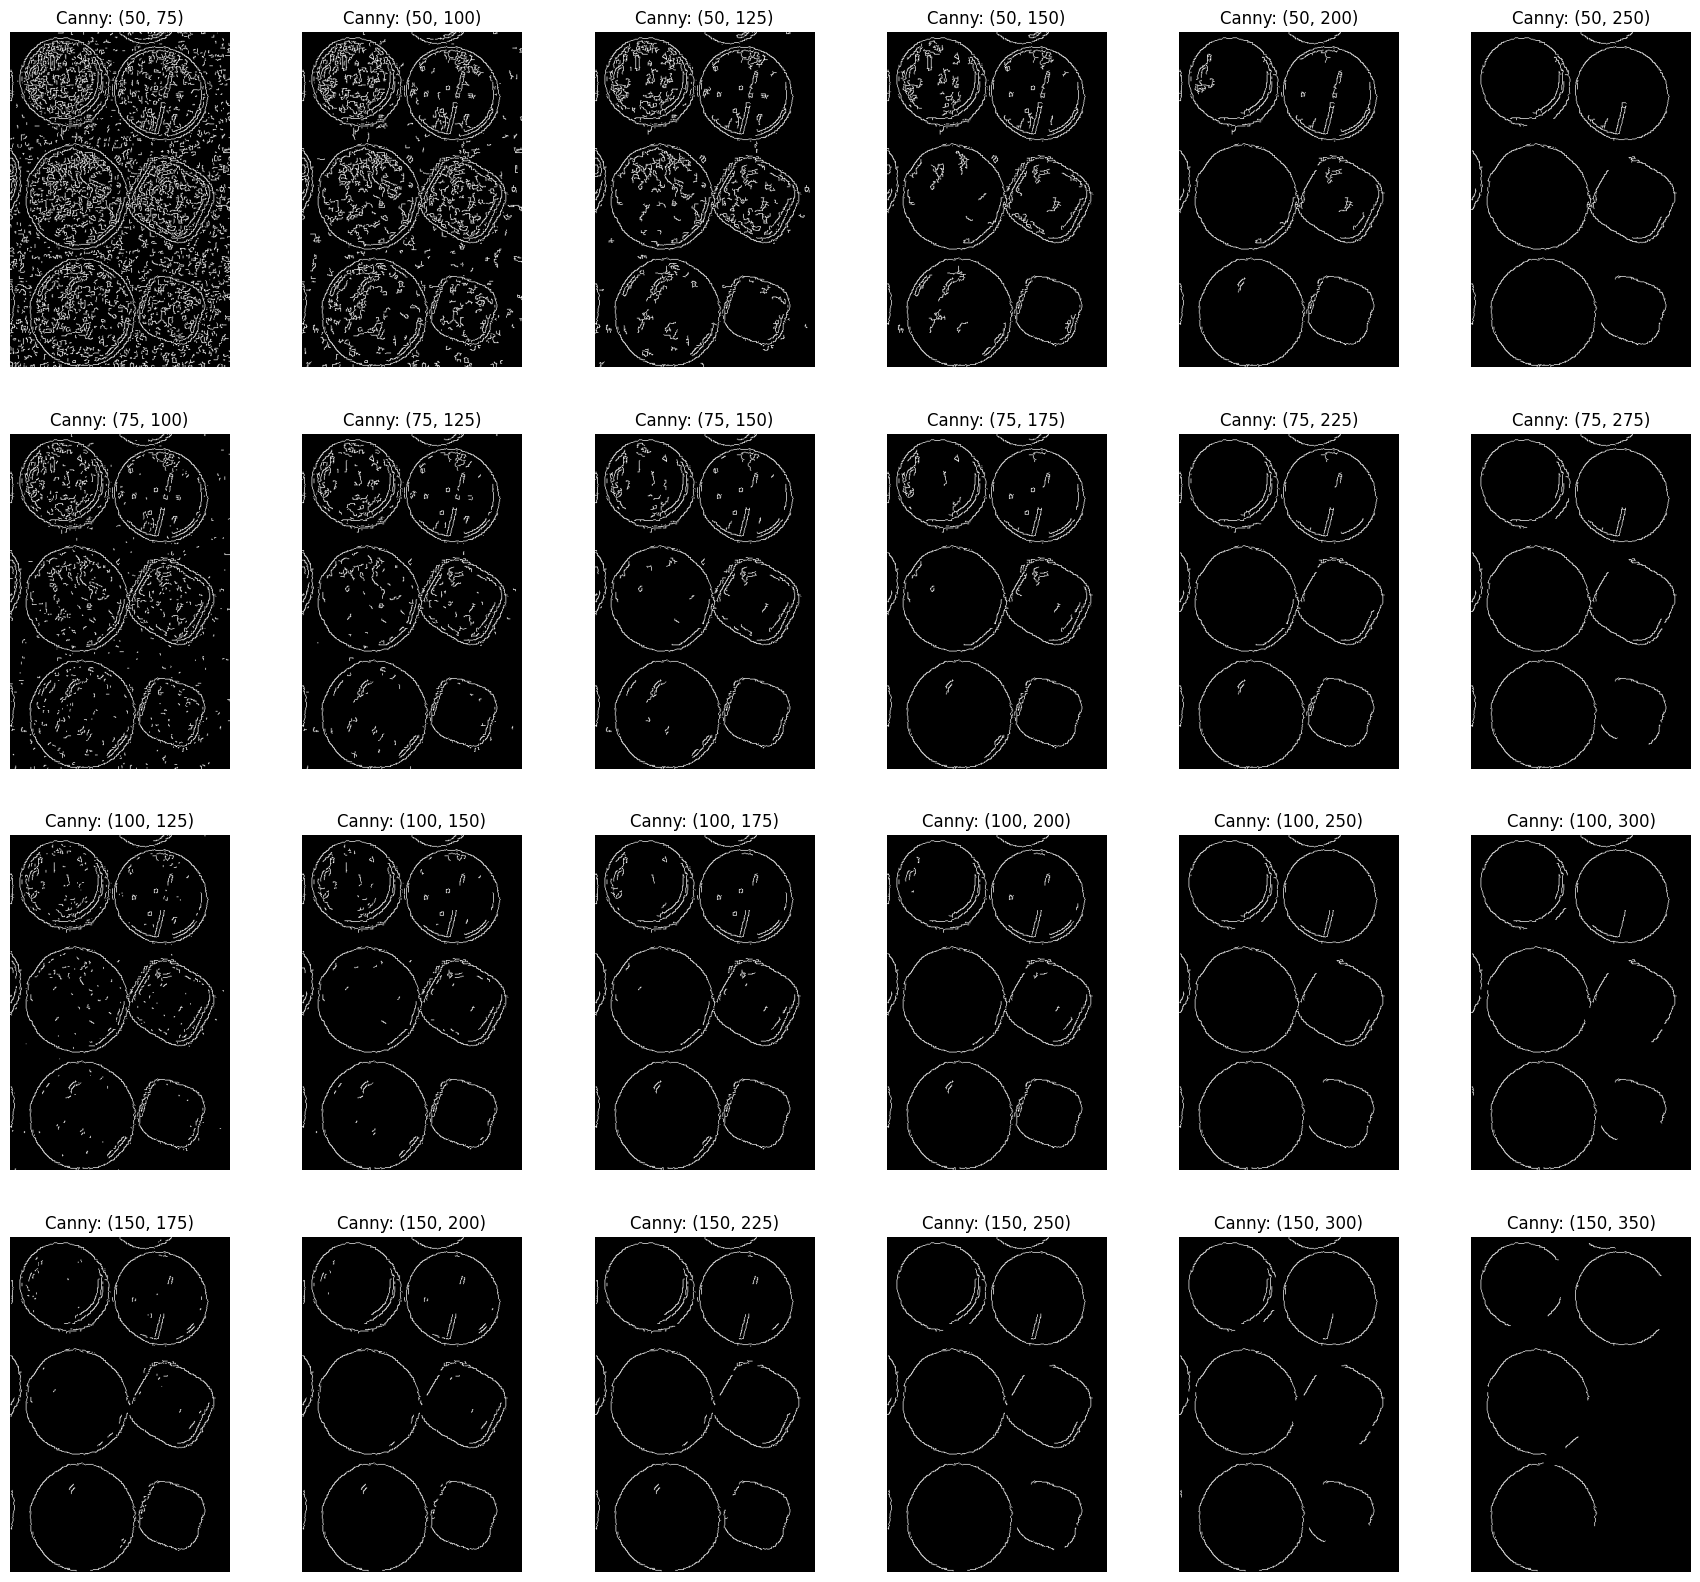

In [32]:
data = [
    (t1, t1 + t2, cv2.Canny(cv2.blur(cv2.equalizeHist(coins_noise), (5, 5)), threshold1=t1, threshold2=t1 + t2))
    for t1 in [50, 75, 100, 150] for t2 in [25, 50, 75, 100, 150, 200]    
]
plot_canny(data)

Odnajdywanie konturów przy pomocy canny po zastosowaniu metody wyrównania histogramu, zdaje się być bardziej stabilne i mniej wrażliwe na dobór parametrów.

---

##### Zad. 4: Transformacja do rozkładu docelowego

Dla obrazów `hare_gray` i `hare_color` wykonaj transformacje na składowych S i/lub V modelu HSV, przechodząc do wybranego (założonego) rozkładu docelowego, tak aby zmaksymalizować możliwość wyodrębnienia obiektu z otoczenia (zająca) przy użyciu algorytmu binaryzacji Otsu.

Podpowiedź: przedstawiona we wstępie teoretycznym transformacja obu rozkładów (źródłowego i docelowego) do rozkładu jednostajnego _nie musi_ zostać faktycznie wykonana (dlatego nie używaj w zadaniu funkcji `cv2.equalizeHist`)! Wystarczy porównywanie ze sobą wartości ze skumulowanych rozkładów (rysunek 3).

Podpowiedź 2: [cv2.LUT](https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gab55b8d062b7f5587720ede032d34156f)

**4A** (`hare_gray`):

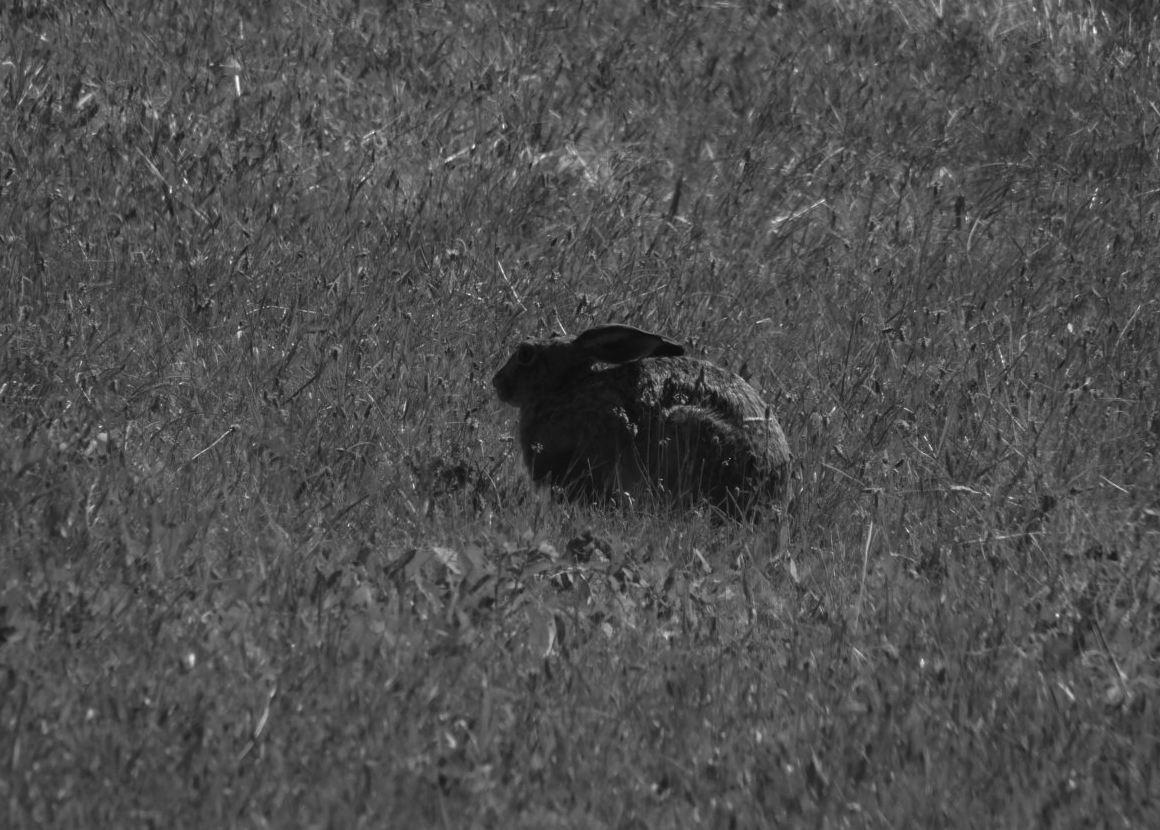

In [4]:
hare_gray = cv2.imread('../dane-1-4/Zajac.jpg', cv2.IMREAD_GRAYSCALE)
Image.fromarray(hare_gray)

Rozwiązanie:

Jako rodziny rozkładów docelowych używane będą mikstury rozkładów normalnych. W poniższych zadaniach zostaną użyte głównie mikstury dwóch gaussów, gdyż są to rozkłady bimodalne, które są wskazane przy metodach binaryzacji, gdyż każda moda odpowiada innemu z dwóch klastrów docelowych.

In [101]:
def generate_gaussian_mix(means, vars, mixes, size=100_000):
    """Generates 1D gaussian mixture distribution and normalizes it to [0, 255]"""
    
    assert sum(mixes) == 1, "Mixing coefficients should add up to one"

    target = np.concatenate(
        [
            np.random.normal(mean, var, int(mix * size)) for mean, var, mix in zip(means, vars, mixes)
        ]
    )

    target = np.rint(255 * (target - target.min()) / target.ptp()).astype(np.uint8)
    return target

def prepare_lut(src, dst):
    """Prepares look-up table for distribution shift"""

    src_hist = cv2.calcHist(src[None, ...], [0], None, [256], (0, 256), accumulate=False)
    src_distributant = 255 * np.cumsum(src_hist) / src.size

    dst_hist = cv2.calcHist(dst[None, ...], [0], None, [256], (0, 256), accumulate=False)
    dst_distributant = 255 * np.cumsum(dst_hist) / dst.size

    lut = np.argmin(np.abs(dst_distributant[None, ...] - src_distributant[..., None]), axis=1)

    lut_hist = cv2.calcHist(lut[None, ...].astype(np.uint8), [0], None, [256], (0, 256), accumulate=False)
    lut_distributant = 255 * np.cumsum(lut_hist) / lut.size

    return lut, src_distributant, dst_distributant, lut_distributant

def apply_lut_otsu(src, lut):
    """Applies otsu thresholding"""

    out = cv2.LUT(src, lut).astype(np.uint8)
    lut_threshold, out_lut = cv2.threshold(out, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    src_threshold, out_src = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return out, out_lut, lut_threshold, out_src, src_threshold

def plot_lut(
    src, out, out_lut, lut_threshold, out_src, src_threshold, dst, 
    src_distributant, dst_distributant, lut_distributant, lut
):
    fig, axes = plt.subplots(3, 3, figsize=(20, 12))

    # Plot histograms
    axes[0, 0].set_title("Source \n\n Distribution")
    axes[0, 0].axvline(x=src_threshold, color='r', label=f'otsu threshold = {src_threshold}')
    axes[0, 0].hist(src.flatten(), bins=255)
    axes[0, 0].legend()
    axes[0, 0].grid()

    axes[0, 1].set_title("Obtained \n\n Distribution")
    axes[0, 1].axvline(x=lut_threshold, color='r', label=f'otsu threshold = {lut_threshold}')
    axes[0, 1].hist(out.flatten(), bins=255)
    axes[0, 1].legend()
    axes[0, 1].grid()

    axes[0, 2].set_title("Target ditribution")    
    axes[0, 2].hist(dst.flatten(), bins=255)
    axes[0, 2].grid()

    # Plot images
    axes[1, 0].set_title("Image")
    axes[1, 0].imshow(src, cmap="gray")

    axes[1, 1].set_title("Image")
    axes[1, 1].imshow(out, cmap="gray")

    axes[1, 2].set_title("Distributants")
    axes[1, 2].plot(src_distributant, label="Source")
    axes[1, 2].plot(dst_distributant, label="Target")
    axes[1, 2].plot(lut_distributant, label="Obtained")
    axes[1, 2].grid()
    axes[1, 2].legend()

    # Plot otsu
    axes[2, 0].set_title("Otsu")
    axes[2, 0].imshow(out_src, cmap="gray")

    axes[2, 1].set_title("Otsu")
    axes[2, 1].imshow(out_lut, cmap="gray")

    axes[2, 2].set_title("Obtained LUT mapping")
    axes[2, 2].plot(lut, color="r")
    axes[2, 2].grid()

    plt.show()

In [108]:
def perform_distribution_change(src, means, vars, mixes):
    """Performs distribution change and visualization of results"""

    dst = generate_gaussian_mix(means, vars, mixes)
    lut, src_distributant, dst_distributant, lut_distributant = prepare_lut(src, dst)
    out, out_lut, lut_threshold, out_src, src_threshold = apply_lut_otsu(src, lut)

    plot_lut(
        src, 
        out, 
        out_lut, 
        lut_threshold, 
        out_src, 
        src_threshold, 
        dst,
        src_distributant,
        dst_distributant,
        lut_distributant,
        lut
    )

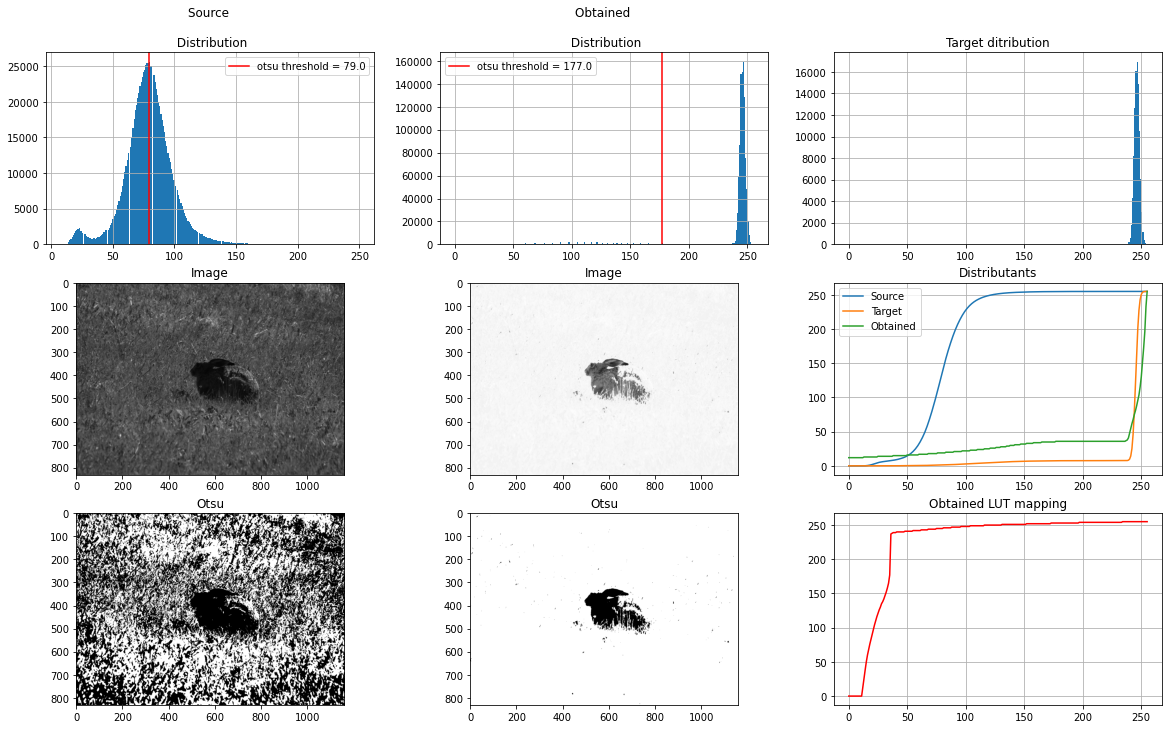

In [109]:
perform_distribution_change(hare_gray, [-3, 3], [1.5, 0.1], [0.03, 0.97])

Jak widać, histogram obrazu wyjściowego nie pokrywa się w 100% z rozkładem docelowym - jednak jest dosyć zbliżony. Zmiana dystrybucji wartości pikseli na obrazie przyniosła oczekiwane rezultaty, obraz został dużo lepiej zbinaryzowany przy użyciu metody otsu niż obraz źródłowy. 

---

**4B** (`hare_color`):

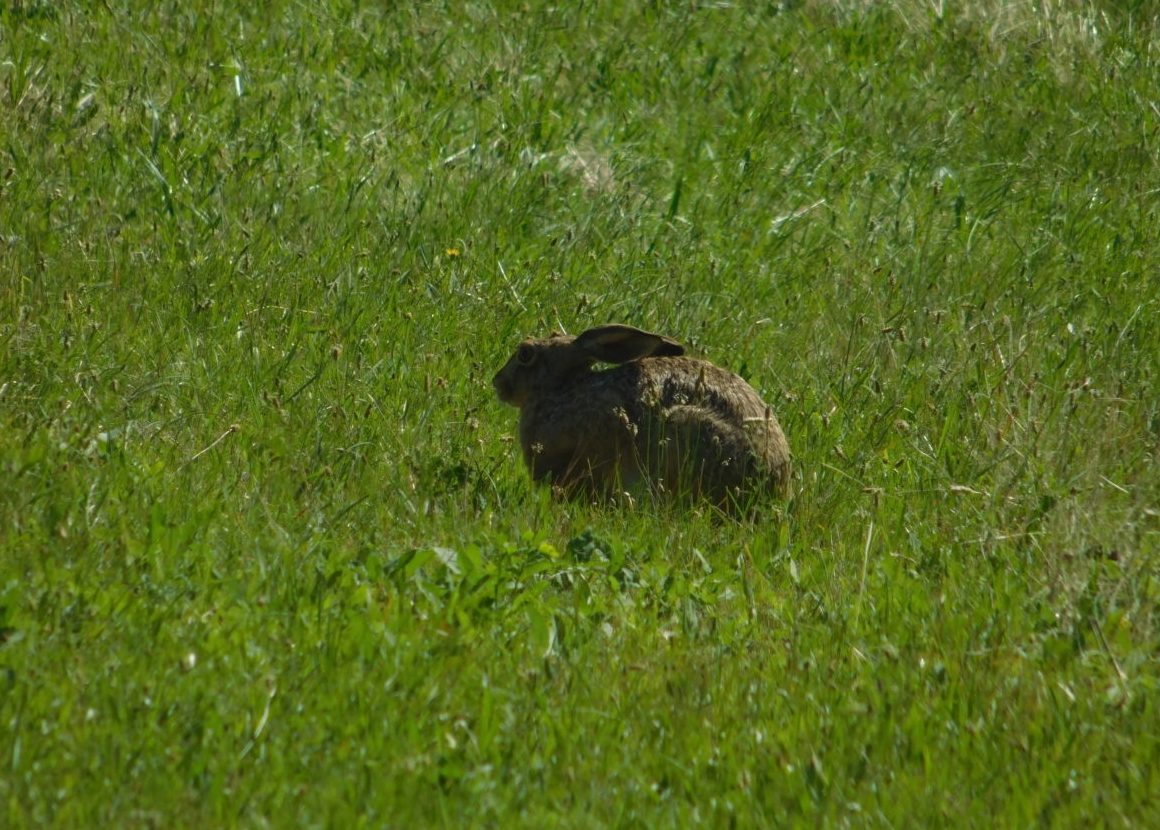

In [103]:
hare_color = cv2.imread('../dane-1-4/Zajac_kolor.jpg')
Image.fromarray(hare_color[..., ::-1])

Rozwiązanie:

In [146]:
hare_hsv = cv2.cvtColor(hare_color, cv2.COLOR_BGR2HSV)

a) HUE

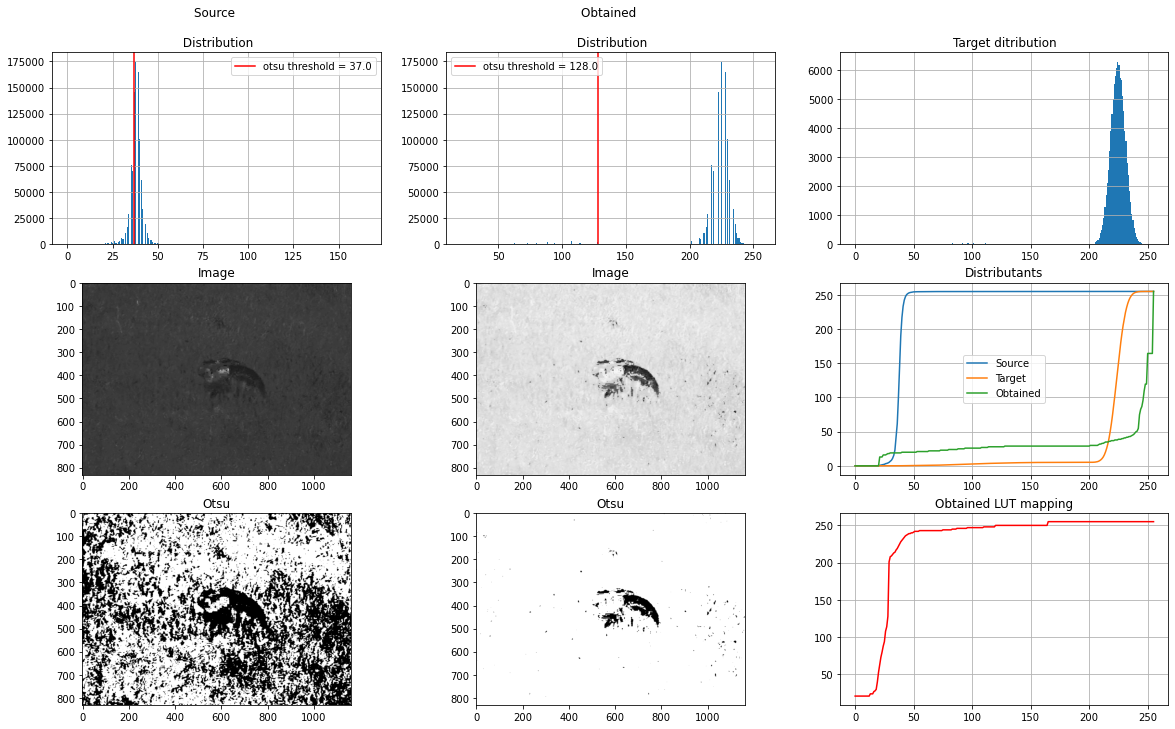

In [115]:
perform_distribution_change(hare_hsv[..., 0], [-3, 3], [1.5, 0.3], [0.02, 0.98])

b) SATURATION

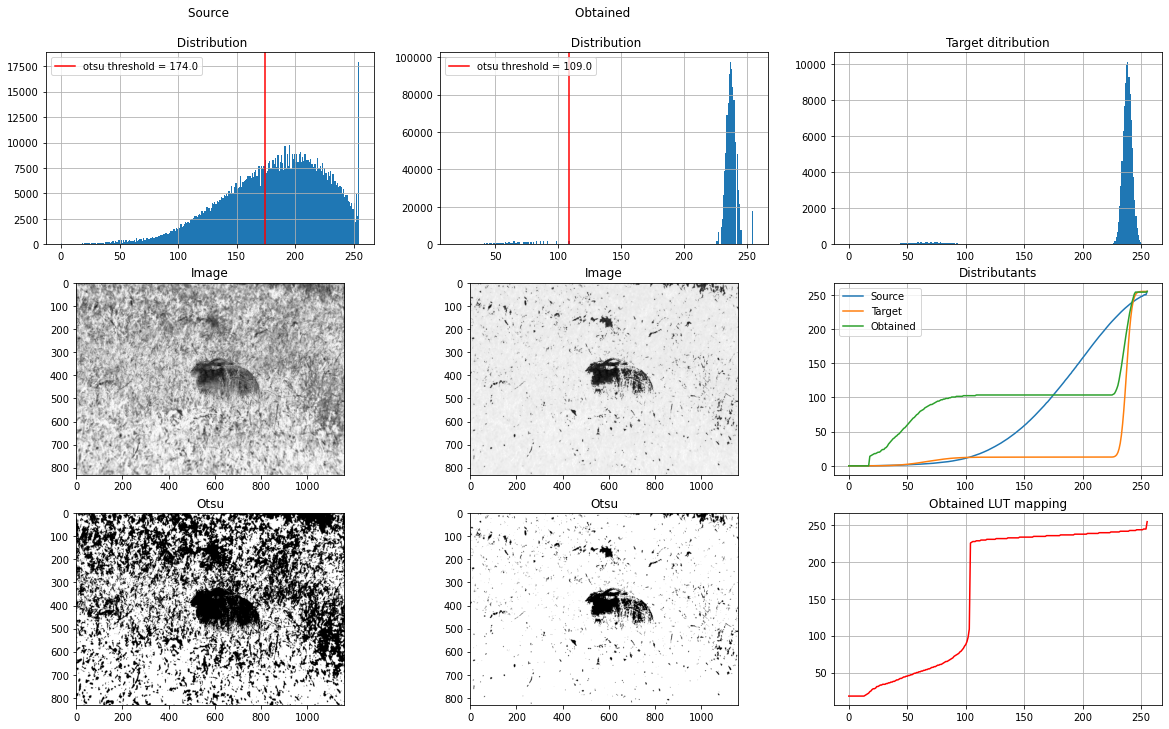

In [125]:
perform_distribution_change(hare_hsv[..., 1], [-8, 1], [1.0, 0.2], [0.05, 0.95])

c) VALUE

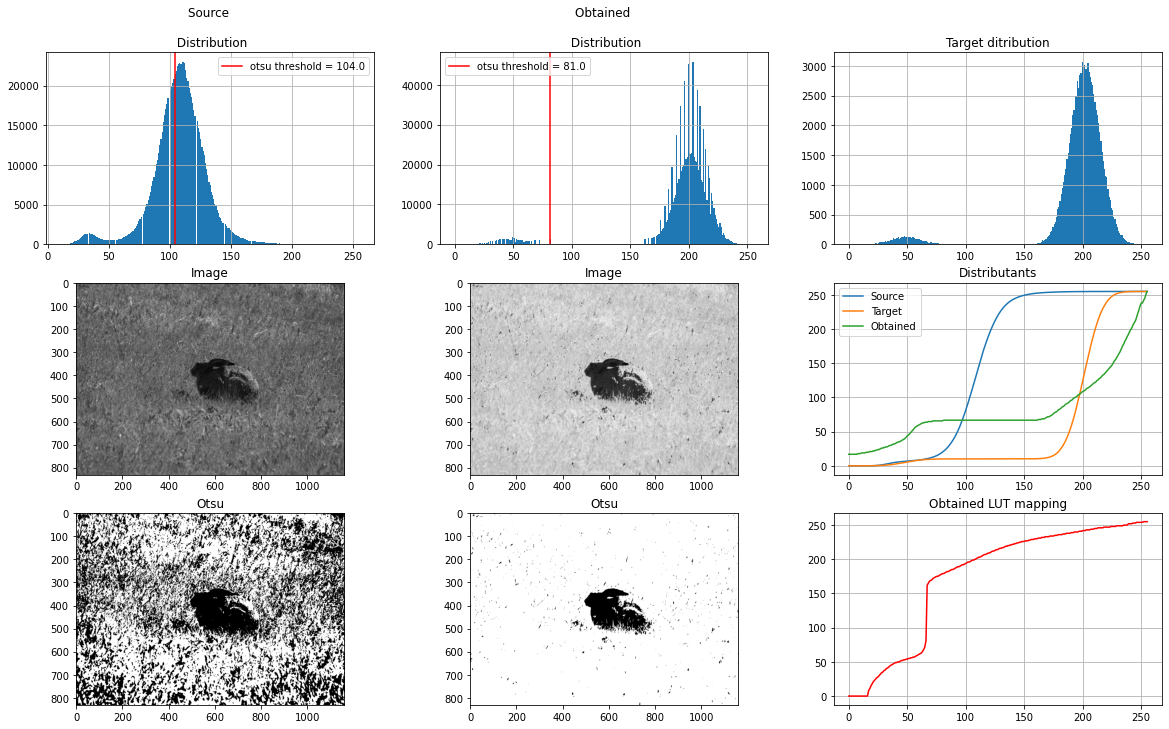

In [137]:
perform_distribution_change(hare_hsv[..., 2], [-5, 1], [0.5, 0.5], [0.04, 0.96])

Najlepsze rezultaty zostały uzyskane dla kanału V, który odpowiada za nasycenie barw na obrazie. 